<a href="https://colab.research.google.com/github/vedarushi20/smart-resume-analysis/blob/main/SpitiValley.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q earthengine-api geemap geopandas rasterio opencv-python segmentation-models-pytorch

import ee
import geemap
from google.colab import auth
auth.authenticate_user()

ee.Authenticate()
ee.Initialize(project='glacial-lake-ai')  # Change to your GCP project ID


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.5 MB/s eta 0:00:00


In [3]:
# Approximate bounding box for Spiti Valley
aoi = ee.Geometry.Rectangle([77.5, 32.0, 78.5, 33.0])
Map = geemap.Map(center=[32.5, 78.0], zoom=8)
Map.addLayer(aoi, {}, "AOI")
Map


Map(center=[32.5, 78.0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(…

In [4]:
sentinel = ee.ImageCollection("COPERNICUS/S2_SR") \
  .filterBounds(aoi) \
  .filterDate('2022-08-01', '2022-09-30') \
  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10)) \
  .median().clip(aoi)

Map.addLayer(sentinel, {"bands": ["B4", "B3", "B2"], "min": 0, "max": 3000}, "Sentinel-2 RGB")
Map


Map(center=[32.5, 78.0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(…

In [5]:
export_img = sentinel.select(['B2', 'B3', 'B4']).toFloat()
task = ee.batch.Export.image.toDrive(
    image=export_img,
    description='Spiti_Sentinel2_RGB',
    folder='glacial_lake_spiti',
    fileNamePrefix='spiti_rgb',
    region=aoi,
    scale=10
)
task.start()


In [7]:
import torch
import cv2
import segmentation_models_pytorch as smp

# Load image
img = cv2.imread('spiti_rgb.tif')
img_resized = cv2.resize(img, (256, 256)) / 255.0

# UNet segmentation (dummy output for now)
model = smp.Unet(encoder_name='resnet34', encoder_weights='imagenet', in_channels=3, classes=1)
model.eval()
# y_pred = model(torch.tensor(img_resized).unsqueeze(0).permute(0,3,1,2).float())

# TODO: Threshold & polygonize output


error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [8]:
task = ee.batch.Export.image.toDrive(
    image=export_img,
    description='Spiti_Sentinel2_RGB',
    folder='glacial_lake_spiti',
    fileNamePrefix='spiti_rgb',
    region=aoi,
    scale=10,
    maxPixels=1e13
)
task.start()


In [9]:
import time

print("Checking task status...")

while task.active():
    print('Task is still running...')
    time.sleep(10)

print('Final task state:', task.status()['state'])


Checking task status...
Task is still running...
Task is still running...
Task is still running...
Task is still running...
Task is still running...
Task is still running...
Task is still running...
Task is still running...
Task is still running...
Task is still running...
Task is still running...
Task is still running...
Task is still running...
Task is still running...
Task is still running...
Task is still running...
Task is still running...
Task is still running...
Task is still running...
Task is still running...
Task is still running...
Task is still running...
Task is still running...
Task is still running...
Task is still running...
Task is still running...
Task is still running...
Task is still running...
Task is still running...
Task is still running...
Task is still running...
Task is still running...
Task is still running...
Task is still running...
Task is still running...
Task is still running...
Task is still running...
Final task state: COMPLETED


In [10]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [11]:
!ls /content/drive/MyDrive/glacial_lake_spiti


spiti_rgb.tif


In [12]:
!cp /content/drive/MyDrive/glacial_lake_spiti/spiti_rgb.tif .


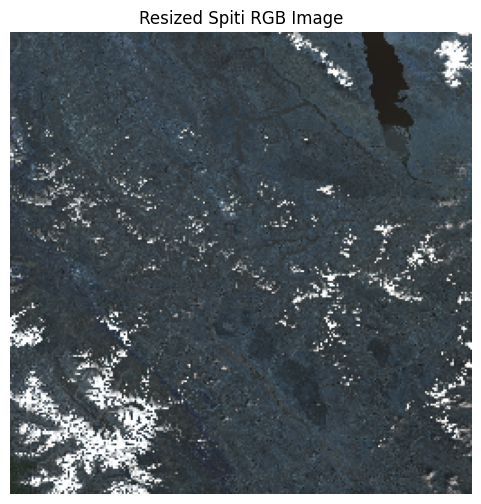

In [13]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Load the .tif using rasterio
with rasterio.open("spiti_rgb.tif") as src:
    img = src.read([1, 2, 3])  # RGB bands
    img = np.transpose(img, (1, 2, 0))  # Rearranged to HWC (height x width x channels)

# Normalize and resize
img = img / 10000.0  # Sentinel values normalization
img_resized = cv2.resize(img, (256, 256))

# Visualize the resized image
plt.figure(figsize=(6, 6))
plt.imshow(img_resized)
plt.title("Resized Spiti RGB Image")
plt.axis("off")
plt.show()


In [14]:
# 🧊 Glacial Lake Segmentation with Pretrained UNet

In [15]:
!pip install segmentation-models-pytorch torch torchvision rasterio geopandas opencv-python --quiet

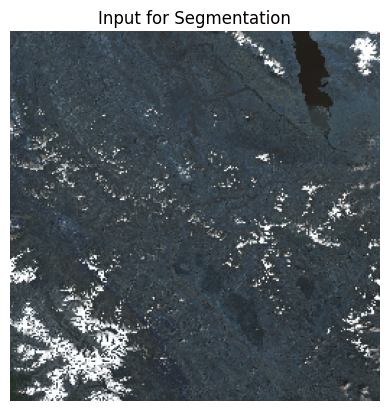

In [16]:
import rasterio
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load Sentinel-2 image from previous step
with rasterio.open("spiti_rgb.tif") as src:
    img = src.read([1, 2, 3])  # RGB bands
    img = np.transpose(img, (1, 2, 0))  # Convert to HWC format

# Normalize and resize for UNet input
img = img / 10000.0
img_resized = cv2.resize(img, (256, 256))

plt.imshow(img_resized)
plt.title("Input for Segmentation")
plt.axis("off")
plt.show()


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

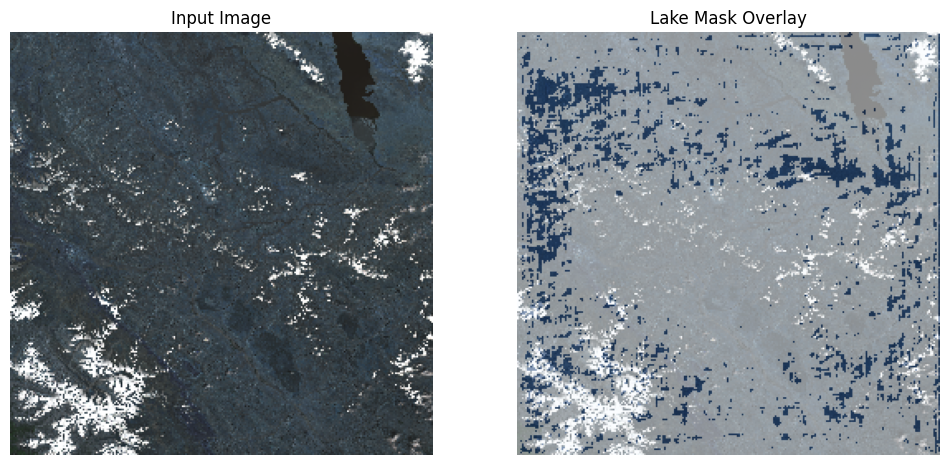

Exported: glacial_lakes_detected.geojson


In [17]:
# 📦 Install if missing
!pip install -q segmentation-models-pytorch torch torchvision rasterio geopandas folium shapely

import torch
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import rasterio
from rasterio.features import shapes
from shapely.geometry import shape
import geopandas as gpd
import cv2
import folium

# 1. Reload & Resize Image (ensure 'spiti_rgb.tif' is present)
with rasterio.open('spiti_rgb.tif') as src:
    img_full = src.read([1,2,3]).transpose(1,2,0) / 10000.0
img_resized = cv2.resize(img_full, (256,256))

# 2. Load Pretrained UNet (ResNet34 backbone)
model = smp.Unet(encoder_name='resnet34', encoder_weights='imagenet', in_channels=3, classes=1)
model.eval()

# 3. Inference
input_tensor = torch.tensor(img_resized).permute(2,0,1).unsqueeze(0).float()
with torch.no_grad():
    output = model(input_tensor)
mask_prob = torch.sigmoid(output)[0,0].numpy()
binary_mask = (mask_prob > 0.5).astype(np.uint8)

# 4. Visualize Overlay
fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].imshow(img_resized); ax[0].set_title('Input Image'); ax[0].axis('off')
ax[1].imshow(img_resized); ax[1].imshow(binary_mask, alpha=0.5, cmap='Blues')
ax[1].set_title('Lake Mask Overlay'); ax[1].axis('off')
plt.show()

# 5. Extract Polygons
with rasterio.open('spiti_rgb.tif') as src:
    transform = src.transform; crs = src.crs
polygons = [shape(geom) for geom, val in shapes(binary_mask, transform=transform) if val==1]
gdf = gpd.GeoDataFrame(geometry=polygons, crs=crs)

# 6. Save GeoJSON
out_fn = 'glacial_lakes_detected.geojson'
gdf.to_file(out_fn, driver='GeoJSON')
print(f"Exported: {out_fn}")

# 7. Simple Folium Map
centroid = gdf.geometry.unary_union.centroid
m = folium.Map(location=[centroid.y, centroid.x], zoom_start=12)
folium.GeoJson(gdf, name='Detected Lakes').add_to(m)
m
